In [3]:
# import torch

# if torch.cuda.is_available():
#     DEVICE = 'cuda:0'
#     print('Running on the GPU')
# else:
#     print('no cuda')

no cuda


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from nuscenes.nuscenes import NuScenes as V2XSimDataset
from mmseg.apis import init_model
# import mmseg
# from mmseg.apis import inference_model, init_model, show_result_pyplot

# from Scene.Scene import Scene
from Vehicle.Vehicle import Vehicle
from Registration.utils import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
config_file = '.\\checkpoints\\deepLabv3Plus\\deeplabv3plus_r50-d8_4xb2-40k_cityscapes-512x1024.py'
checkpoint_file = '.\\checkpoints\\deepLabv3Plus\\weights.pth'

model = init_model(config_file, checkpoint_file, device='cuda:0')

In [3]:
datapath = "D:\\Dataset-Thesis\\temp\\V2X Sim Mini\\V2X-Sim-2.0-mini"
v2x_sim = V2XSimDataset(version='v2.0-mini', dataroot=datapath, verbose=True)

Loading NuScenes tables for version v2.0-mini...
Loading nuScenes-lidarseg...
32 category,
5 attribute,
4 visibility,
157 instance,
130 sensor,
130 calibrated_sensor,
13000 ego_pose,
12 log,
1 scene,
100 sample,
13000 sample_data,
15292 sample_annotation,
3 map,
600 lidarseg,
Done loading in 0.357 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [4]:
examples = [[1,4,1], #v1_ID, v2_ID, time
            [],
            []]

In [5]:
exaplme_ID = 0 #change this, if you want different scene
v1_ID, v2_ID, time = examples[exaplme_ID]

In [6]:
v1 = Vehicle(v2x_sim,v1_ID)
v2 = Vehicle(v2x_sim,v2_ID)

In [21]:
# v1.showVideo('CAM_FRONT', delay=5)
# v1.showVideo('LIADR', delay=5)

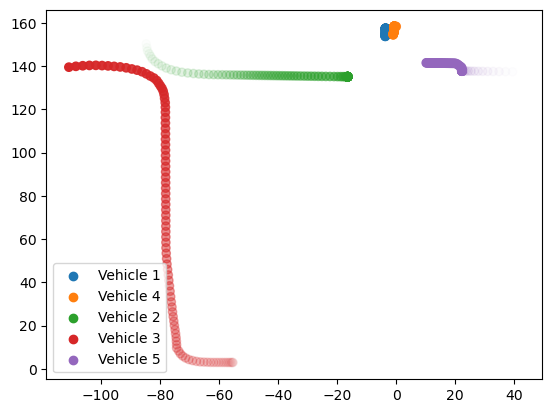

In [7]:
# v1.plotTrajectory(othervehicles=[v2])

In [5]:
Scene1, masks1 = v1.generateScene(model, time)
Scene2, masks2 = v2.generateScene(model, time)

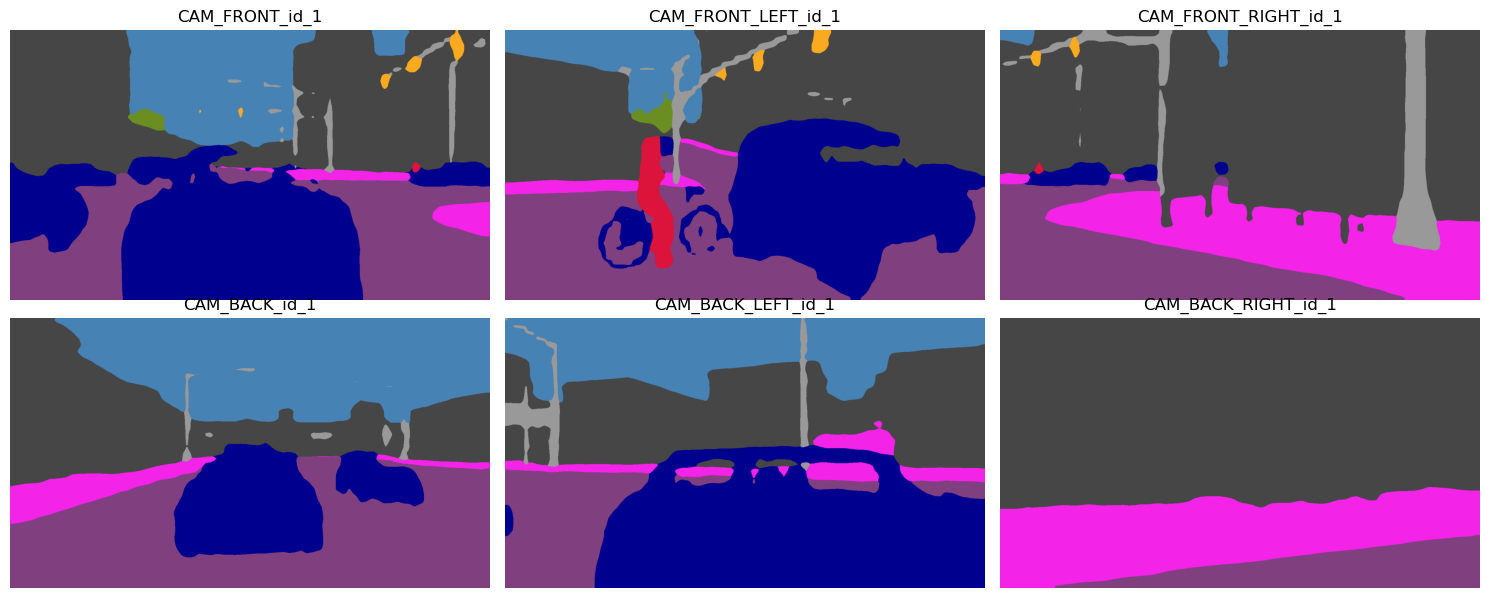

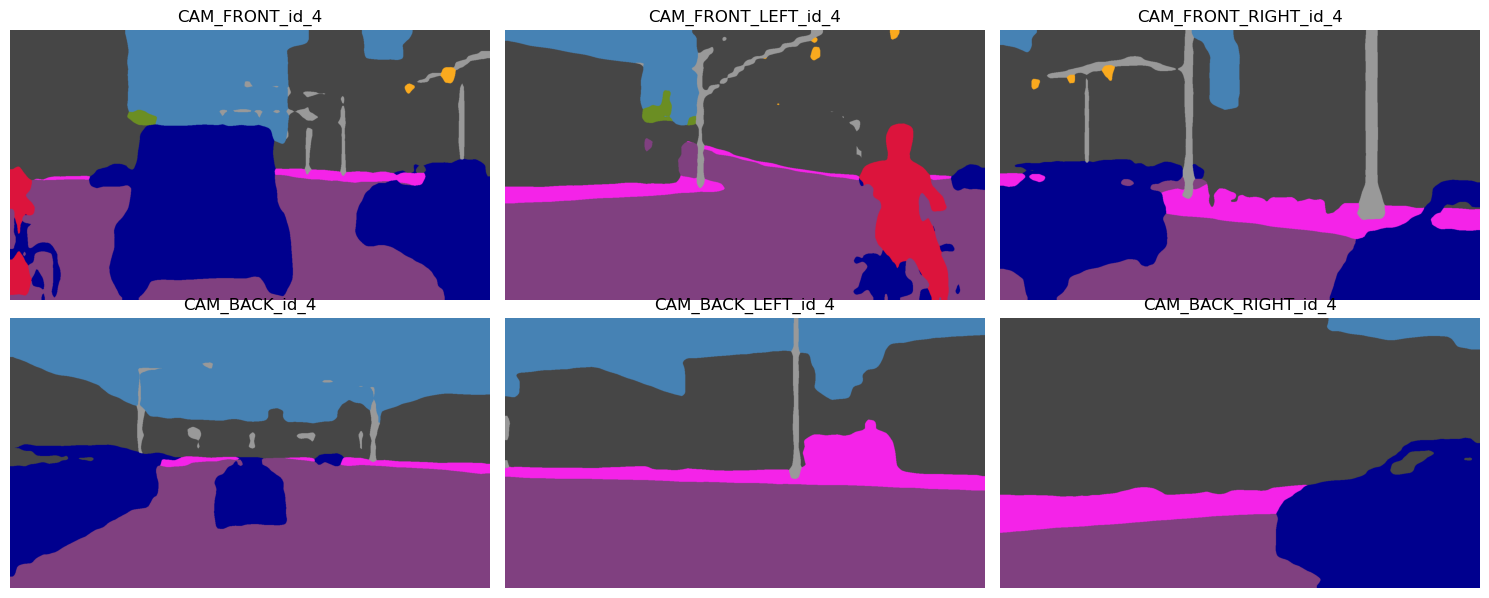

In [6]:
v1.showSegImages(model, time, opacity=1, masks=masks1)
v2.showSegImages(model, time, opacity=1, masks=masks2)

In [15]:
# Scene1.visualizePCD()
# Scene4.visualizePCD()

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


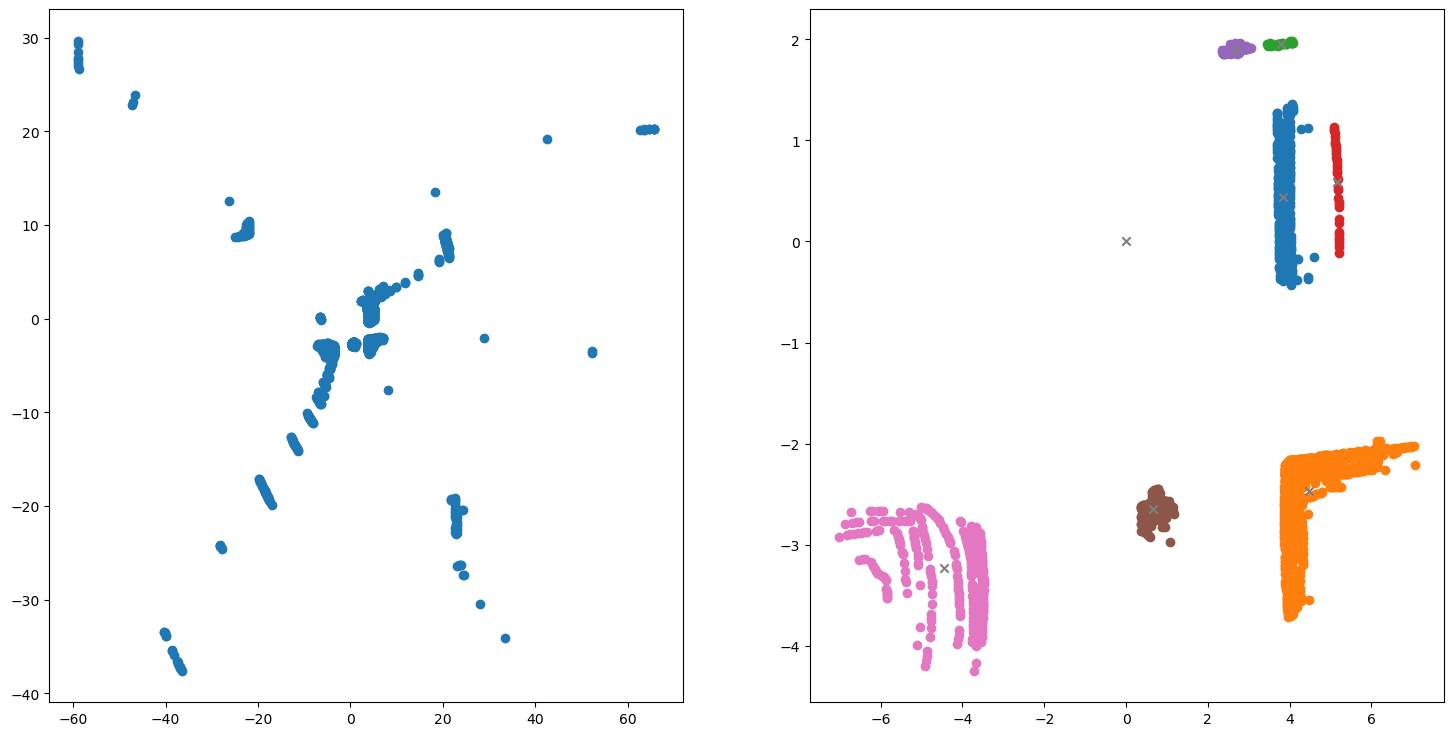

In [8]:
x = Scene2.findcenters(_min_points=20, _eps=0.5, className='vehicle', visualize=True)

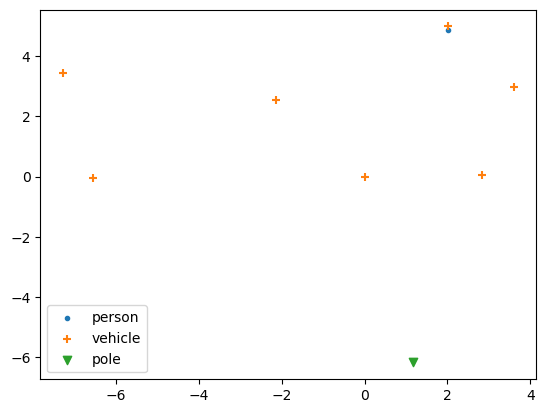

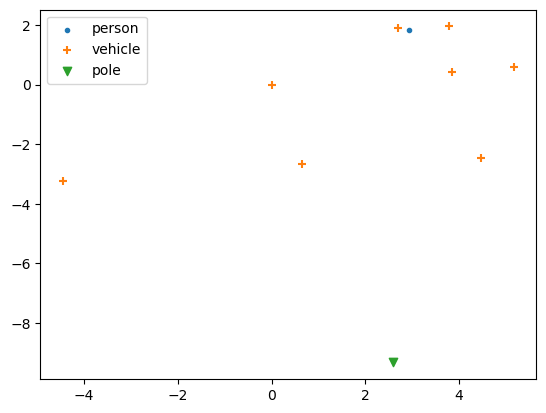

In [7]:
eps =0.5
min_points = 20

# eps = 0.6
# min_points = 17

g1 = Scene1.generateGraph(_min_points=min_points, _eps=eps, classNames=['person', 'vehicle', 'pole'])
g1.plotGraph()

g2 = Scene2.generateGraph(_min_points=min_points, _eps=eps, classNames=['person', 'vehicle', 'pole'])
g2.plotGraph()

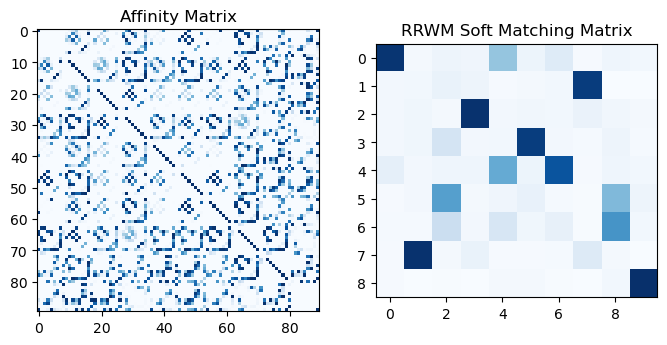

In [8]:
affM, matchMatrix = matchGraph(g1, g2)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title('Affinity Matrix')
plt.imshow(affM, cmap='Blues')

plt.subplot(1, 2, 2)
plt.title('RRWM Soft Matching Matrix')
plt.imshow(matchMatrix, cmap='Blues')

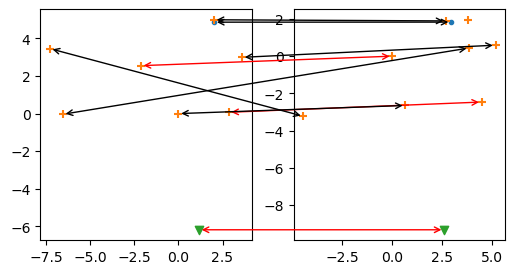

In [9]:
plotMatching(g1, g2, matchMatrix)

In [10]:
TransMatrix = getTransforamtionMatrix_from_MatchingMatrix(g1, g2, matchMatrix, 4)
draw_registration_result(Scene1, Scene2, TransMatrix)

In [11]:
TransMatrix_GT = get_GT_tranfMatrix_V1_2_V2(v1, v2, time)
error = compareTransformation(TransMatrix, TransMatrix_GT, 'degrees')
print(error)
print(np.linalg.norm(error[0]))

(array([0.4992011 , 0.40602091, 0.09277728]), array([-1.58795066,  0.09937786, -2.3348701 ]))
0.6501248661574198


In [13]:
regResult = performICP(Scene1, Scene2, TransMatrix, threshold=0.5)
T_final = copy.deepcopy(regResult.transformation)
draw_registration_result(Scene1,Scene2, T_final)
error = compareTransformation(T_final,TransMatrix_GT, 'degrees')
print(error)
print(np.linalg.norm(error[0]))

(array([0.03364281, 0.19381037, 0.05398432]), array([-2.19306816, -0.05518994, -1.31033193]))
0.2039818708879627


In [ ]:
# (array([-0.68252107,  0.30653239,  0.23600754]), array([-0.73473387, -0.15329697, -2.79943644])) p2p fitness=1